In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf

In [3]:
!bazel build -c opt //im2txt/...

Loading: 
Loading: 0 packages loaded
INFO: Analysed 17 targets (0 packages loaded).
Building: no action
INFO: Found 17 targets...
Building: no action
[0 / 1] [-----] BazelWorkspaceStatusAction stable-status.txt
INFO: Elapsed time: 0.145s, Critical Path: 0.00s
[1 / 1] no action
INFO: Build completed successfully, 1 total action


In [4]:
import sys
import collections

In [5]:
sys.path.insert(0, 'bazel-bin/im2txt/run_inference.runfiles/im2txt/')

In [6]:
from __future__ import absolute_import
from im2txt import configuration
from im2txt.inference_utils import caption_generator
from im2txt import inference_wrapper
from im2txt.inference_utils import vocabulary

In [7]:
tf.logging.set_verbosity(tf.logging.INFO)

In [8]:
checkpoint_path = '/Users/aghasy/tmp/im2sem/model/3/model.ckpt-1000000'

In [9]:
model = inference_wrapper.InferenceWrapper()
config = configuration.ModelConfig()
restore_fn = model.build_graph_from_config(config, checkpoint_path)

INFO:tensorflow:Building model.


In [10]:
def test_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]
    if not_initialized_vars:
        print 'Not initalized varibles are: ', [str(i.name) for i in not_initialized_vars]
        # from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
        # print_tensors_in_checkpoint_file(checkpoint_path, all_tensors=True, tensor_name='')
    assert not not_initialized_vars

In [11]:
with tf.Session() as sess:
    restore_fn(sess)
    test_uninitialized(sess)

INFO:tensorflow:Loading model from checkpoint: /Users/aghasy/tmp/im2sem/model/3/model.ckpt-1000000
INFO:tensorflow:Restoring parameters from /Users/aghasy/tmp/im2sem/model/3/model.ckpt-1000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-1000000


In [12]:
sys.path.insert(0, '..')
sys.path.insert(0, '../slim/')

In [13]:
from object_detection.utils import ops as utils_ops

In [14]:
!cd ..; protoc object_detection/protos/*.proto --python_out=.

In [15]:
sys.path.insert(0, '../object_detection')
from utils import label_map_util
from utils import visualization_utils as vis_util

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [16]:
PATH_TO_LABELS = os.path.abspath('../object_detection/data/mscoco_label_map.pbtxt')
NUM_CLASSES = 90

In [17]:
label_map  = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [18]:
TEST_IMAGES_DIR = '/Users/aghasy/Desktop/tmp/test_images/'
TEST_IMAGE_PATHS = [os.path.join(TEST_IMAGES_DIR, x) for x in  os.listdir(TEST_IMAGES_DIR)]
IMAGE_SIZE = (12, 8)

In [19]:
image_tensor = tf.get_default_graph().get_tensor_by_name('image_feed:0')

In [20]:
def get_detection_tensors():
    ops = tf.get_default_graph().get_operations()
    all_tensor_names = {output.name for op in ops for output in op.outputs}
    tensor_dict = {}
    for key in [
            'num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes', 'detector_image'
    ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                    tensor_name)
    return tensor_dict

In [21]:
fetch_dict = get_detection_tensors()

In [22]:
def draw_detection_result(output_dict):
    # all outputs are float32 numpy arrays, so convert types as appropriate
    image_np = output_dict['detector_image'][0]
    # Visualization of the results of a detection.
    image_np = np.array(image_np).astype(np.uint8)[:,:,:3]
    vis_util.visualize_boxes_and_labels_on_image_array(
         image_np,
         output_dict['detection_boxes'][0],
         output_dict['detection_classes'][0].astype(np.uint8),
         output_dict['detection_scores'][0],
         category_index,
         instance_masks=None,
         use_normalized_coordinates=True,
         line_thickness=8)
    return image_np

/Users/aghasy/Desktop/tmp/test_images/230144620067202.jpg


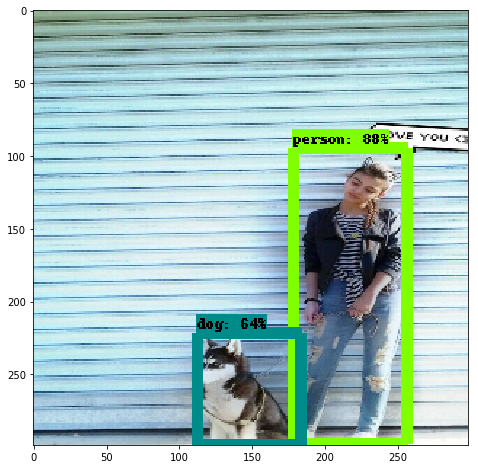

In [23]:
with tf.Session() as sess:
    for image_path in TEST_IMAGE_PATHS[10:11]:
        # Actual detection.
        print (image_path)
        # Get handles to input and output tensors

        with open(image_path, 'r') as content_file:
            content = content_file.read()
        output_dict = sess.run(fetch_dict, feed_dict={image_tensor: content})
        image_np = draw_detection_result(output_dict)
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)

In [24]:
# print [i.name for i in g.get_operations()]

In [25]:
# tf.get_default_graph().get_operations()

In [26]:
vocab_file = '/Users/aghasy/tmp/im2sem/model/word_counts.txt'
vocab = vocabulary.Vocabulary(vocab_file)

INFO:tensorflow:Initializing vocabulary from file: /Users/aghasy/tmp/im2sem/model/word_counts.txt
INFO:tensorflow:Created vocabulary with 11520 words


In [27]:
image_embedding = tf.get_default_graph().get_tensor_by_name('image_embedding/MatMul:0')

In [28]:
scope = tf.get_variable_scope()
scope.reuse_variables()

In [29]:
# tf.global_variables()

In [30]:
with tf.variable_scope('lstm'):
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(
        num_units=config.num_lstm_units, state_is_tuple=True)
    zero_state = lstm_cell.zero_state(1, dtype=tf.float32)
    _, initial_state = lstm_cell(image_embedding, zero_state)
    initial_state = tf.concat(initial_state, axis=1)

In [31]:
beam_size = 5
max_seq_size = 100

In [32]:
with tf.variable_scope("seq_embedding"):
    embedding_map = tf.get_variable(
              name="map",
              shape=[config.vocab_size, config.embedding_size])

In [36]:
def cond(i, complete_captions, complete_captions_logprob, partial_states, partial_captions, partial_captions_logprob):
    return tf.shape(complete_captions_logprob)[0] < beam_size


def body(i, # int()
         complete_captions, # int(captions_cout, max_seq_size)
         complete_captions_logprob, # float(captions_cout)
         partial_states, # float(beam_size, 2 * lstm_size)
         partial_captions, # int(beam_size, patial_captions_len)
         partial_captions_logprob # float(beam_size)
        ):
    
    tf.get_variable_scope().reuse_variables()

    # float(beam_size)
    words = partial_captions[:, i] 
    
    with tf.device("/cpu:0"): 
        # float(beam_size, lstm_size)
        seq_embeddings = tf.nn.embedding_lookup(embedding_map, words) 

    # (float(beam_size, lstm_size), float(beam_size, lstm_size))
    state_tuple = tf.split(partial_states, num_or_size_splits=2, axis=1) 
    
    # float(beam_size, lstm_size), LSTMStateTuple(c=float(beam_size, lstm_size), h=float(beam_size, lstm_size))
    lstm_outputs, state_tuple = lstm_cell(inputs=seq_embeddings, state=state_tuple)
    
    # float(beam_size, 2 * lstm_size)
    partial_states = tf.concat(state_tuple, axis=1)
    
    # float(beam_size, word_count)
    with tf.variable_scope('logits') as s:
        logits = tf.contrib.layers.fully_connected(
            inputs=lstm_outputs,
            num_outputs=config.vocab_size,
            activation_fn=None,
            reuse=True,
            weights_initializer=None,
            scope=s)

    # float(beam_size, word_count)
    softmax = tf.log(tf.nn.softmax(logits, name="softmax"))
    
    # float(beam_size, beam_size), int(beam_size, beam_size)
    softmax_values, softmax_indices = tf.nn.top_k(softmax, k=beam_size)
    
#     with tf.control_dependencies([
#         tf.assert_greater(softmax_values, tf.fill(tf.shape(softmax_values), 1e-12))
#     ]):
#         # float(beam_size, beam_size)
#         softmax_values = tf.identity(softmax_values)
        
    
    # float(beam_size, beam_size)
    # 0.1 0.1 0.1
    # 0.2 0.2 0.2
    # 0.0 0.0 0.0
    log_mat = tf.reshape(tf.tile(partial_captions_logprob, [beam_size]), [beam_size, -1])
    
    # float(1, beam_size, patial_captions_len)
    # s1 s2 s3
    partial_mat = tf.expand_dims(partial_captions, axis=0)
    
    # float(beam_size, beam_size, patial_captions_len) 
    # s1 s2 s3
    # s1 s2 s3
    # s1 s2 s3
    partial_mat = tf.tile(partial_mat, [beam_size, 1, 1])
    
    # float(beam_size, beam_size, patial_captions_len)
    # s1 s1 s1
    # s2 s2 s2
    # s3 s3 s3
    partial_mat = tf.transpose(partial_mat, perm=[1, 0, 2])
    
    # float(beam_size, beam_size)
    # 0.1 0.1 0.1   0.4, 0.3, 0.2
    # 0.2 0.2 0.2 + 0.3, 0.3, 0.1
    # 0.0 0.0 0.0   0.5, 0.3, 0.2
    log_mat = log_mat + softmax_values
    
    # float (beam_size, beam_size, patial_captions_len + 1)
    partial_mat = tf.concat([partial_mat, tf.expand_dims(softmax_indices, axis=2)], axis=2)
    
    # float (beam_size * beam_size)
    log_mat = tf.reshape(log_mat, shape=[-1])
    
    # float (beam_size), int(beam_size)
    sel_logprob, sel_ind = tf.nn.top_k(log_mat, k=beam_size)
    
    # bool (beam_size)
    end_of_seq = tf.equal(tf.gather(tf.reshape(softmax_indices, shape=[-1]), sel_ind), vocab.end_id)
    
    # int(beam_size, patial_captions_len)
    sel_partial_mat = tf.gather(tf.reshape(partial_mat, shape=[beam_size* beam_size, -1]), sel_ind)
    
    # int(new_complete_captions_count, patial_captions_len)
    new_complete_captions = tf.boolean_mask(sel_partial_mat, end_of_seq)
    
    new_complete_captions_shape = tf.shape(new_complete_captions)
    
    new_complete_captions_end = tf.fill(dims=[new_complete_captions_shape[0], max_seq_size-new_complete_captions_shape[1]], value=vocab.end_id)
    
    new_complete_captions = tf.concat([new_complete_captions, new_complete_captions_end], axis=1)
    
    complete_captions = tf.concat([complete_captions, new_complete_captions] , axis=0)
    
    complete_captions_logprob = tf.concat([complete_captions_logprob, tf.boolean_mask(sel_logprob, end_of_seq)], axis=0)
    

    sel_states = tf.gather(partial_states, tf.floordiv(sel_ind, beam_size))
    
    not_end_of_seq = tf.equal(end_of_seq, False)
    
    partial_states = tf.boolean_mask(sel_states, not_end_of_seq)
    partial_states.set_shape((beam_size, partial_states.get_shape()[1]))
    partial_captions = tf.boolean_mask(sel_partial_mat, not_end_of_seq)
    partial_captions.set_shape((beam_size, None))
    partial_captions_logprob = tf.boolean_mask(sel_logprob, not_end_of_seq)
    partial_captions_logprob.set_shape((beam_size))
    return i+1, complete_captions, complete_captions_logprob, partial_states, partial_captions, partial_captions_logprob


iter_count, complete_captions, complete_captions_logprob, partial_states, partial_captions, partial_captions_logprob = tf.while_loop(
    loop_vars=(
        tf.constant(0), # iter_count
        tf.zeros([0, max_seq_size], dtype=tf.int32), # complete_captions
        tf.zeros([0], dtype=tf.float32), # complete_captions_logprob
        tf.tile(initial_state, [beam_size, 1]), # partial_states
        tf.constant(vocab.start_id, shape=[beam_size, 1]), # partial_captions
        tf.zeros([beam_size], dtype=tf.float32) # partial_captions_logprob
    ),
    shape_invariants=(
        tf.TensorShape(()),
        tf.TensorShape((None, max_seq_size)),
        tf.TensorShape((None)),
        tf.TensorShape((beam_size, initial_state.get_shape()[1])),
        tf.TensorShape((beam_size, None)),
        tf.TensorShape((beam_size))
    ),
    cond=cond, body=body, maximum_iterations=max_seq_size)

In [37]:
fetch_dict['complete_captions'] = complete_captions
fetch_dict['iter_count'] = iter_count
fetch_dict['complete_captions_logprob'] = complete_captions_logprob

INFO:tensorflow:Loading model from checkpoint: /Users/aghasy/tmp/im2sem/model/3/model.ckpt-1000000
INFO:tensorflow:Restoring parameters from /Users/aghasy/tmp/im2sem/model/3/model.ckpt-1000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-1000000
/Users/aghasy/Desktop/tmp/test_images/230144620067202.jpg
(10, array([[ 1,  0, 11, 10, 17, 21, 12,  0, 44,  3,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2],
       [ 1,  0, 11, 10, 17, 21, 12,  0, 44,  3,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
    

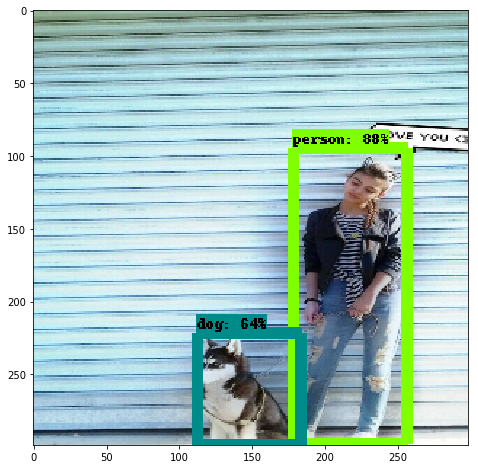

In [38]:
with tf.Session() as sess:
    restore_fn(sess)
    # only for testing
#     test_uninitialized(sess)
    for image_path in TEST_IMAGE_PATHS[10:11]:
        # Actual detection.
        print (image_path)
        # Get handles to input and output tensors

        with open(image_path, 'r') as content_file:
            content = content_file.read()
        output_dict = sess.run(fetch_dict, feed_dict={image_tensor: content})
        draw_detection_result(output_dict)
        print(output_dict['iter_count'],  output_dict['complete_captions'], output_dict['complete_captions_logprob'])
        plt.figure(figsize=IMAGE_SIZE)
        plt.imshow(image_np)